# Deep Knowledge Tracing
Authors: Lisa Wang, Angela Sy, Larry Liu

### Task: Predict which block is coming next in an Abstract Syntax Tree (AST), and use the learned hidden representation as an embedding for this AST. This embedding can then be used for predicting the next AST.

Input: For each of the N students, we have a time series of blocks from an AST. 

- input shape (num_asts, num_timesteps, num_blocks)
    - num_timesteps is the max sequence length of blocks that we are taking into account.
    - num_blocks is the total number of blocks that appear in an HOC problem.

Output: At each timestep, we are predicting the next block.
- Output shape (num_asts, num_timesteps, num_blocks). (one-hot encoding)

The truth matrix contains the desired output for a given input, and is used to compute the loss as well as train/val/test accuracies.
- Truth shape (num_asts, num_timesteps) Values are in range (0, num_blocks)


In [35]:
# Python libraries
import numpy as np
import theano
import theano.tensor as Tensor
import lasagne
import random
import sys
import csv
import time
import matplotlib.pyplot as plt
import pickle
from sklearn.cross_validation import KFold
from sklearn.utils import shuffle
# allows plots to show inline in ipython notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Import our own modules
import utils
import model_predict_block as model
import visualize
from constants import *

In [4]:
# hyperparameters
hidden_size = 128 # size of hidden layer of neurons
learning_rate = 1e-2
lr_decay = 0.995
reg_strength = 2e-2
grad_clip = 10
batchsize = 32
num_epochs = 8
dropout_p = 0.5
num_lstm_layers = 1
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'

In [14]:
HOC_NUM = 7
DATA_SZ = -1
train_data, val_data, test_data, all_data, num_timesteps, num_blocks  =\
utils.load_dataset_predict_block(hoc_num=HOC_NUM, data_sz=DATA_SZ)

print 'num_timesteps {}'.format(num_timesteps)

X_train, mask_train, y_train = train_data
X_val, mask_val, y_val = val_data
X_test, mask_test, y_test = test_data
print 'X_train shape {}'.format(X_train.shape)
print 'mask_train shape {}'.format(mask_train.shape)
print 'y_train shape {}'.format(y_train.shape)
print 'X_val shape {}'.format(X_val.shape)
print 'X_test shape {}'.format(X_test.shape)
print X_train[:10,:15:]
print mask_train[:10,:15]
print y_train[:10]

print utils.convert_to_block_strings(y_train[:10])


Preparing network inputs and targets, and the block maps...
Trajectory matrix shape (5926, 20, 15)
Inputs and targets done!
num_timesteps 19
X_train shape (5185, 19, 15)
mask_train shape (5185, 19)
y_train shape (5185, 19)
X_val shape (370, 19, 15)
X_test shape (371, 19, 15)
[[[ 0.  1.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  1. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  1. ...,  0.  0.  0.]
  [ 0.  0.  1. ...,  0.  0.  0.]
  [ 0.  0.  1. ...,  0.  0.  0.]]

 [[ 0.  1.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]
  [ 1.  0.  0. ...,  0.  0.  0.]]

 [[ 0.  1.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  ..., 
  [ 0.  0.  1. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.  0.]]

 ..., 
 [[ 0.  1.  0. ...,  0.  0.  0.]
  [ 0.  0.  1. ...,  0.  0.  0.]
  [ 0.  0.  0. ...,  0.  0.

In [88]:
# create model
print num_blocks
train_loss_acc, compute_loss_acc, probs, generate_hidden_reps, compute_pred = model.create_model(num_timesteps, num_blocks, hidden_size, learning_rate, \
                                                             grad_clip, dropout_p, num_lstm_layers)

6
Building network ...
Computing updates ...
Compiling functions ...
Compiling done!


In [89]:
# Training!
train_losses, train_accs, train_corrected_accs, val_losses, val_accs, val_corrected_accs = model.train(train_data, val_data, train_loss_acc, compute_loss_acc,\
                                                              compute_pred, num_epochs=num_epochs, batchsize=batchsize, record_per_iter=True)

Starting training :)...
Total training iterations: 504
Ep 0 	iter 1  	loss 1.79028, train acc 20.72, train corr acc 16.72, val acc 49.26, val corr acc 1.20
Ep 0 	iter 2  	loss 1.74787, train acc 51.48, train corr acc 0.67, val acc 48.68, val corr acc 0.07
Ep 0 	iter 3  	loss 1.62221, train acc 48.36, train corr acc 0.00, val acc 48.64, val corr acc 0.00
Ep 0 	iter 4  	loss 1.41561, train acc 48.52, train corr acc 0.00, val acc 48.64, val corr acc 0.00
Ep 0 	iter 5  	loss 1.64868, train acc 44.57, train corr acc 0.00, val acc 48.64, val corr acc 0.00
Ep 0 	iter 6  	loss 1.40385, train acc 47.53, train corr acc 0.00, val acc 50.34, val corr acc 3.32
Ep 0 	iter 7  	loss 1.26705, train acc 56.74, train corr acc 2.59, val acc 52.23, val corr acc 7.00
Ep 0 	iter 8  	loss 1.29537, train acc 58.06, train corr acc 8.60, val acc 52.60, val corr acc 7.70
Ep 0 	iter 9  	loss 1.39847, train acc 50.99, train corr acc 10.24, val acc 52.89, val corr acc 8.27
Ep 0 	iter 10  	loss 1.33388, train acc 53.

In [91]:
# Evaluate on test set
test_loss, test_raw_acc, test_corrected_acc, pred_test = model.check_accuracy(test_data, compute_loss_acc, dataset_name='test')

Testing...
Final results:
  test loss:			1.068040
  test raw accuracy:		61.09 %
  test corrected accuracy:	27.75 %


In [93]:
X_all, mask_all, _ = all_data
ast_embeddings = generate_hidden_reps(X_all, mask_all)

In [94]:
print ast_embeddings.shape
print X_all.shape

(2314, 256)
(2314, 19, 6)


In [95]:
print ast_embeddings[:10, :10]

[[-0.09564256  0.12010601 -0.14471232  0.03233207  0.0092966  -0.30389927
  -0.00350801 -0.28258349 -0.56213086  0.1975325 ]
 [-0.00952602  0.09160703 -0.12065622  0.12200775  0.00967831 -0.24530033
   0.05101336 -0.25496152 -0.07230631  0.43806564]
 [-0.25903327  0.13675017 -0.3137715   0.23230389  0.00969295 -0.48429453
   0.00064772 -0.13579737 -0.37562295  0.036104  ]
 [-0.24501731  0.06020714 -0.146662    0.20097479  0.00366048 -0.40478106
   0.004316   -0.14788355 -0.2099546   0.04359592]
 [-0.09496466  0.08787513 -0.11709445  0.04719868  0.00596931 -0.33923934
   0.00067602 -0.29179712 -0.52984889  0.29522163]
 [-0.02865978  0.05928655 -0.06830794  0.149172    0.00331502 -0.18569762
   0.00573558 -0.28611373 -0.28784729  0.49670875]
 [-0.07915447  0.10210764 -0.19332581  0.27701947  0.00764762 -0.3643594
  -0.02953888 -0.34072351 -0.18025459  0.0696902 ]
 [-0.08949476  0.1555579  -0.23392714  0.30810338  0.01202019 -0.35497929
  -0.04341698 -0.34705117 -0.3045248   0.04484843]
 

In [96]:
utils.save_ast_embeddings(ast_embeddings, HOC_NUM)

In [ ]:
ast_embeddings_ast_row_to_ast_id_map = pickle.load('map_row_index_to_ast_id_2.pickle')
traj_mat_ast_row_to_ast_id_map = pickle.load()

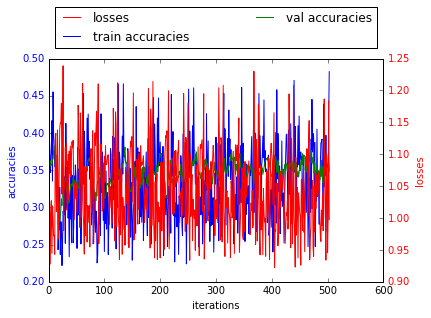

In [72]:
# Visualize the loss and the accuracies for both training and validation sets for each epoch
num_train = train_data[0].shape[0]
visualize.plot_loss_acc('hoc' + str(HOC_NUM) + '_train', train_losses, train_corrected_accs, val_corrected_accs, learning_rate, reg_strength, num_epochs, num_train, xlabel='iterations')

## Experiment: 
Is it possible to train a single model to create embeddings for programs across all Hocs?

In [23]:
# prepare data for all HOCs
X_all_hocs_mat, mask_all_hocs_mat, y_all_hocs_mat, split_indices = utils.load_dataset_predict_block_all_hocs()
# Shuffle
X_all_hocs_mat, mask_all_hocs_mat, y_all_hocs_mat = shuffle(X_all_hocs_mat, mask_all_hocs_mat, y_all_hocs_mat, random_state=0)

Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
(99950, 19, 8)


In [36]:
print X_all_hocs_mat.shape
print mask_all_hocs_mat.shape
print y_all_hocs_mat.shape
num_samples_total, num_timesteps, num_blocks = X_all_hocs_mat.shape

(99950, 19, 8)
(99950, 19)
(99950, 19)


In [ ]:
# trying out sklearn kfold

In [26]:
kf = KFold(num_samples_total, n_folds=6)
print(kf)  

sklearn.cross_validation.KFold(n=99950, n_folds=6, shuffle=False, random_state=None)


In [37]:
# hyperparameters
hidden_size = 128 # size of hidden layer of neurons
learning_rate = 1e-2
lr_decay = 0.995
reg_strength = 2e-2
grad_clip = 10
batchsize = 8
num_epochs = 1
dropout_p = 0.5
num_lstm_layers = 1
theano.config.optimizer='fast_compile'
theano.config.exception_verbosity='high'

In [31]:
train_loss_acc, compute_loss_acc, probs, generate_hidden_reps, compute_pred = model.create_model(num_timesteps, num_blocks, hidden_size, learning_rate, \
                                                             grad_clip, dropout_p, num_lstm_layers)

Building network ...
Computing updates ...
Compiling functions ...
Compiling done!


/Users/lisa1010/anaconda/lib/python2.7/site-packages/theano/scan_module/scan.py:1019: Warning: In the strict mode, all neccessary shared variables must be passed as a part of non_sequences
  'must be passed as a part of non_sequences', Warning)


In [38]:
# Training!
for train_index, val_index in kf:
    print("TRAIN:", train_index, "TEST:", val_index)
    train_data = (X_all_hocs_mat[train_index], mask_all_hocs_mat[train_index],y_all_hocs_mat[train_index])
    val_data = (X_all_hocs_mat[val_index], mask_all_hocs_mat[val_index],y_all_hocs_mat[val_index])
    
    train_losses, train_accs, train_corrected_accs, val_losses, val_accs, val_corrected_accs = model.train(train_data, val_data, train_loss_acc, compute_loss_acc,\
                                                                  compute_pred, num_epochs=num_epochs, batchsize=batchsize, record_per_iter=True)

('TRAIN:', array([16659, 16660, 16661, ..., 99947, 99948, 99949]), 'TEST:', array([    0,     1,     2, ..., 16656, 16657, 16658]))
Starting training :)...
Total training iterations: 10411
Ep 0 	iter 1  	loss 1.98693, train acc 36.84, train corr acc 2.04, val acc 45.52, val corr acc 6.10
Ep 0 	iter 2  	loss 1.99642, train acc 42.76, train corr acc 8.51, val acc 46.69, val corr acc 8.78
Ep 0 	iter 3  	loss 1.69416, train acc 46.05, train corr acc 7.87, val acc 47.24, val corr acc 11.46
Ep 0 	iter 4  	loss 1.73230, train acc 42.76, train corr acc 7.45, val acc 39.99, val corr acc 12.58
Ep 0 	iter 5  	loss 1.75391, train acc 37.50, train corr acc 12.84, val acc 23.49, val corr acc 9.00
Ep 0 	iter 6  	loss 2.41399, train acc 7.89, train corr acc 2.97, val acc 46.98, val corr acc 13.61
Ep 0 	iter 7  	loss 1.59824, train acc 48.68, train corr acc 12.36, val acc 47.56, val corr acc 10.17
Ep 0 	iter 8  	loss 1.59321, train acc 44.74, train corr acc 11.58, val acc 47.48, val corr acc 9.46
Ep 0 

KeyboardInterrupt: 

In [39]:
X_all_hocs_mat, mask_all_hocs_mat, y_all_hocs_mat, split_indices = utils.load_dataset_predict_block_all_hocs()

Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...
Preparing network inputs and targets, and the block maps...


In [40]:
ast_embeddings_all_hocs = generate_hidden_reps(X_all_hocs_mat, mask_all_hocs_mat)

In [42]:
utils.save_ast_embeddings_for_all_hocs(ast_embeddings_all_hocs, split_indices)

In [43]:
print ast_embeddings_all_hocs.shape

(99950, 256)


In [44]:
print ast_embeddings_all_hocs[:10, :10]

[[-0.24856442  0.10019749 -0.0796252  -0.15180447  0.17074073  0.02689021
  -0.37280924 -0.00674305  0.1848056   0.23062699]
 [-0.26208442  0.12359322 -0.1123555  -0.0350733   0.38807956  0.01827913
  -0.21843464 -0.00298318  0.13060198  0.20982095]
 [-0.16009985  0.09530191 -0.0996798  -0.00805891  0.36616792  0.00974815
  -0.17657568 -0.00148262  0.13147062  0.17863403]
 [-0.20231345  0.10337988 -0.17679867  0.05752091  0.34736497 -0.00959668
  -0.1904667  -0.00090355  0.12189703  0.1582936 ]
 [-0.2328481   0.06610216  0.00269448  0.12086811  0.42449915  0.03474641
  -0.12188486 -0.0046818   0.08928466  0.17146715]
 [-0.25416435  0.13397439 -0.17267386  0.01881143  0.40407     0.01572802
  -0.30246928 -0.00157162  0.17562135  0.18961318]
 [-0.18529212  0.04885819 -0.06132809  0.10952254  0.42513228  0.03436801
  -0.09217294 -0.00175755  0.10920363  0.12910401]
 [-0.2649687   0.18198574 -0.06355394 -0.03889779  0.25625495  0.03025404
  -0.26337129 -0.00298908  0.12798115  0.23181765]
